In [6]:
import os, sys, logging, warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"     
warnings.filterwarnings("ignore")                               # глушим всё некритичное
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


logging.getLogger("matplotlib").setLevel(logging.ERROR)
logging.getLogger("urllib3").setLevel(logging.ERROR)
logging.getLogger("folium").setLevel(logging.ERROR)

In [7]:
# ======================================================
# Kaggle notebook: zones clustering + anomaly detection (TensorFlow)
# Input: geo_locations_astana_hackathon.csv 
# ======================================================

import os, gc, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import IFrame, display


try:
    import tensorflow as tf
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "tensorflow-cpu>=2.12,<2.17"])
    import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans

import folium
from folium.plugins import HeatMap
from folium import LayerControl

print("TF:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

TF: 2.18.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
def find_csv(filename="geo_locations_astana_hackathon.csv"):
    for p in Path("/kaggle/input").rglob(filename):
        return str(p)
    if (Path("data")/filename).exists():
        return str(Path("data")/filename)
    if Path(filename).exists():
        return str(Path(filename))
    raise FileNotFoundError(f"CSV {filename} not found in /kaggle/input or ./data")

CSV_PATH = find_csv()
print("CSV_PATH:", CSV_PATH)

CSV_PATH: /kaggle/input/test-db/geo_locations_astana_hackathon.csv


In [3]:
usecols = [c for c in ["randomized_id","lat","lng","spd","azm","alt"]]
df = pd.read_csv(CSV_PATH, usecols=lambda c: c in usecols, low_memory=False)

df = df.dropna(subset=["lat","lng"])
df = df[(df["lat"].between(-90,90)) & (df["lng"].between(-180,180))]

if "spd" in df.columns:
    df["spd"] = pd.to_numeric(df["spd"], errors="coerce").fillna(0)
    df.loc[df["spd"] < 0, "spd"] = 0
else:
    df["spd"] = 0.0

for col in ["azm","alt","randomized_id"]:
    if col not in df.columns:
        df[col] = 0 if col!="randomized_id" else np.arange(len(df))

print("Shape:", df.shape)
display(df.head(3))

Shape: (1262687, 6)


,randomized_id,lat,lng,alt,spd,azm
0,7637058049336049989,51.09546,71.42753,350.53102,0.20681,13.60168
1,1259981924615926140,51.09820,71.41295,348.80161,0.00000,265.67700
2,1259981924615926140,51.09846,71.41212,349.27388,4.34501,307.24530


In [4]:
features = df[["lat","lng","spd","azm"]].to_numpy().astype("float32")
scaler = StandardScaler()
X = scaler.fit_transform(features)

# автоэнкодер

In [8]:
TRAIN_N = min(400_000, len(X))   
rng = np.random.default_rng(42)
idx = rng.choice(len(X), size=TRAIN_N, replace=False)
X_train = X[idx]

LATENT = 8
inp = keras.Input(shape=(X.shape[1],))
h = layers.Dense(64, activation="relu")(inp)
h = layers.Dense(32, activation="relu")(h)
z = layers.Dense(LATENT, name="latent")(h)
h = layers.Dense(32, activation="relu")(z)
h = layers.Dense(64, activation="relu")(h)
out = layers.Dense(X.shape[1])(h)

auto = keras.Model(inp, out)
auto.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
cb = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_loss")]

history = auto.fit(
    X_train, X_train,
    validation_split=0.1,
    epochs=30,
    batch_size=4096,
    verbose=1,
    callbacks=cb
)
auto.save("/kaggle/working/tf_autoencoder.h5")

encoder = keras.Model(auto.input, auto.get_layer("latent").output)


Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.6425 - val_loss: 0.0097
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_loss: 0.0034
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010 - val_loss: 8.3655e-04
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9091e-04 - val_loss: 6.8191e-04
Epoch 8/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.5084e-04 - val_loss: 5.7881e-04
Epoch 9/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.5705e-04 - val_loss: 5.0234e-04
Epoch 10/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8539e-04 - val_loss: 4.4369e-04
Epoch 11/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3257e-04 - val_loss: 3.9752e-04
Epoch 12/30
88/88 ━━━━━━━━━━━

In [9]:
BATCH = 200_000
latents, losses = [], []

for start in range(0, len(X), BATCH):
    end = min(start + BATCH, len(X))
    Xi = X[start:end]
    Zi = encoder.predict(Xi, batch_size=4096, verbose=0)
    Yi = auto.predict(Xi, batch_size=4096, verbose=0)
    mse = np.mean((Yi - Xi)**2, axis=1)
    latents.append(Zi.astype("float32"))
    losses.append(mse.astype("float32"))
    del Xi, Zi, Yi, mse
    gc.collect()

Z_all = np.vstack(latents)
re_all = np.concatenate(losses)
df["anomaly_score"] = re_all

# работа с аномалиями

In [10]:
TH = np.percentile(df["anomaly_score"], 99.0)   # 99.5 — ещё жёстче
df["is_anomaly"] = (df["anomaly_score"] >= TH).astype(np.int8)
print(f"Anomaly threshold={TH:.6g}; share={df['is_anomaly'].mean():.4f}")

Anomaly threshold=0.000750639; share=0.0100


In [11]:
K = 20
try:
    kmeans = KMeans(n_clusters=K, n_init="auto", random_state=42)
    df["cluster"] = kmeans.fit_predict(Z_all)
except MemoryError:
    print("KMeans OOM -> using MiniBatchKMeans")
    kmeans = MiniBatchKMeans(n_clusters=K, batch_size=10000, n_init=10, random_state=42, max_iter=100)
    df["cluster"] = kmeans.fit_predict(Z_all)

cluster_geo = (df.groupby("cluster")
                 .agg(cnt=("cluster","size"),
                      lat_c=("lat","median"),
                      lng_c=("lng","median"),
                      spd_med=("spd","median"),
                      anom_rate=("is_anomaly","mean"))
                 .sort_values("cnt", ascending=False)
                 .reset_index())
display(cluster_geo.head(10))

,cluster,cnt,lat_c,lng_c,spd_med,anom_rate
0,12,93308,51.087614,71.406697,0.064614,0.005423
1,18,85442,51.095566,71.426056,0.043666,0.006402
2,8,82668,51.096620,71.424360,4.229509,0.008806
3,11,82581,51.095180,71.426528,12.464580,0.010390
4,1,78618,51.097890,71.409754,0.031110,0.007428
5,19,70818,51.087139,71.423760,6.407229,0.011466
6,17,70679,51.097815,71.411217,12.562262,0.008277
7,6,69982,51.086630,71.426403,0.181548,0.011117
8,2,69704,51.096500,71.408739,4.940992,0.005925
9,13,67822,51.095199,71.426952,13.663633,0.012105


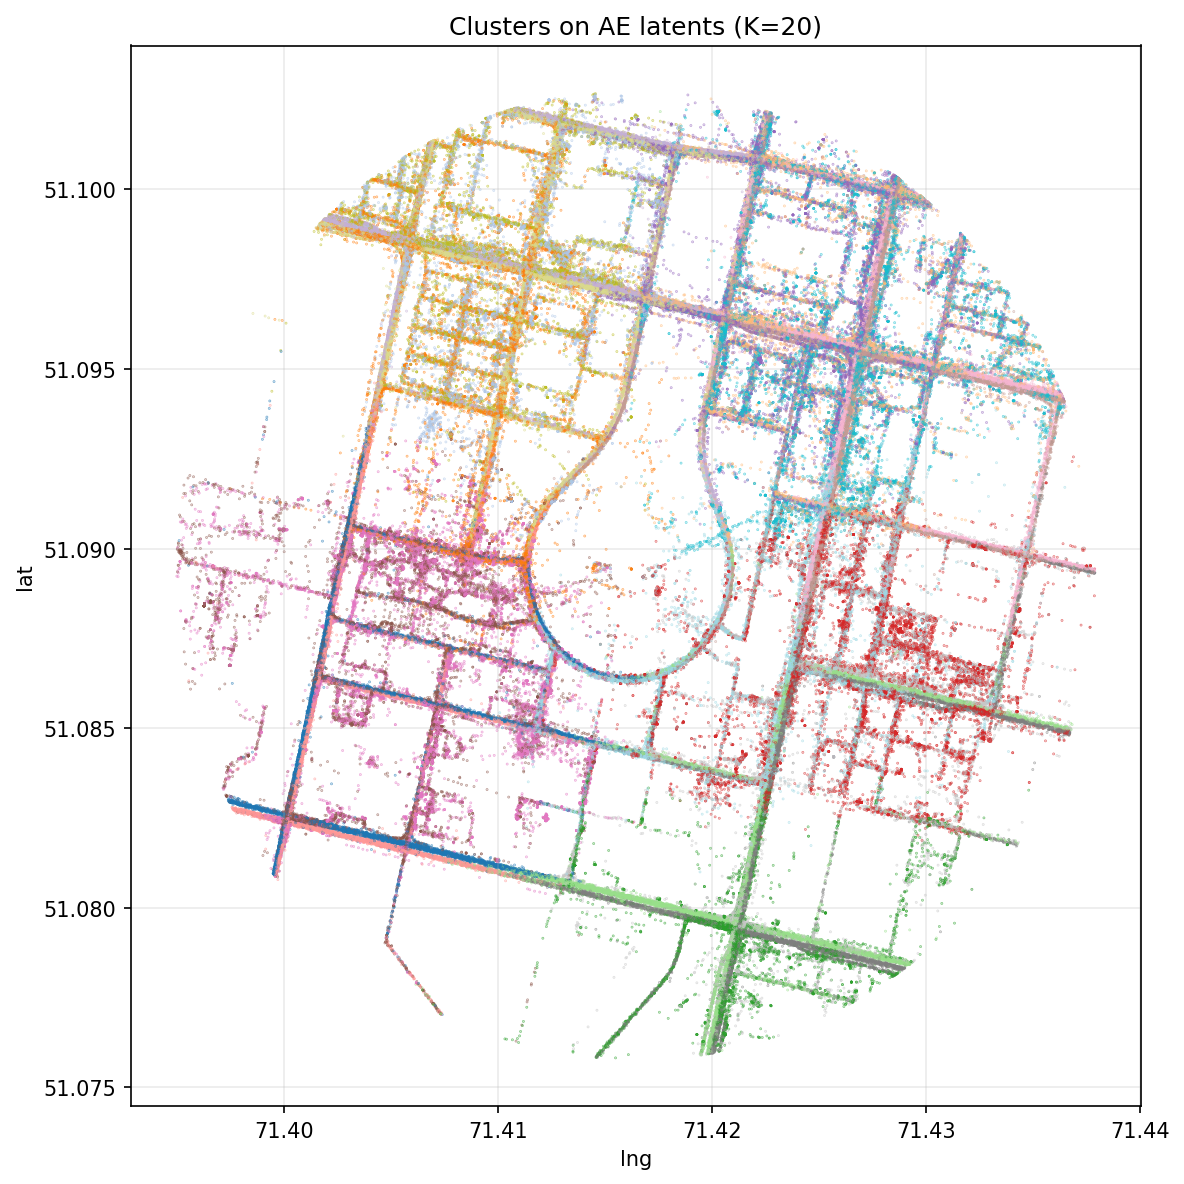

In [12]:
vis = df.sample(min(300_000, len(df)), random_state=1)
plt.figure(figsize=(8,8), dpi=150)
plt.scatter(vis["lng"], vis["lat"], c=vis["cluster"], s=0.1, cmap="tab20", alpha=0.65)
plt.title(f"Clusters on AE latents (K={K})")
plt.xlabel("lng"); plt.ylabel("lat"); plt.grid(True, linewidth=0.2)
plt.tight_layout(); plt.savefig("/kaggle/working/tf_clusters_scatter.png", dpi=200); plt.show()

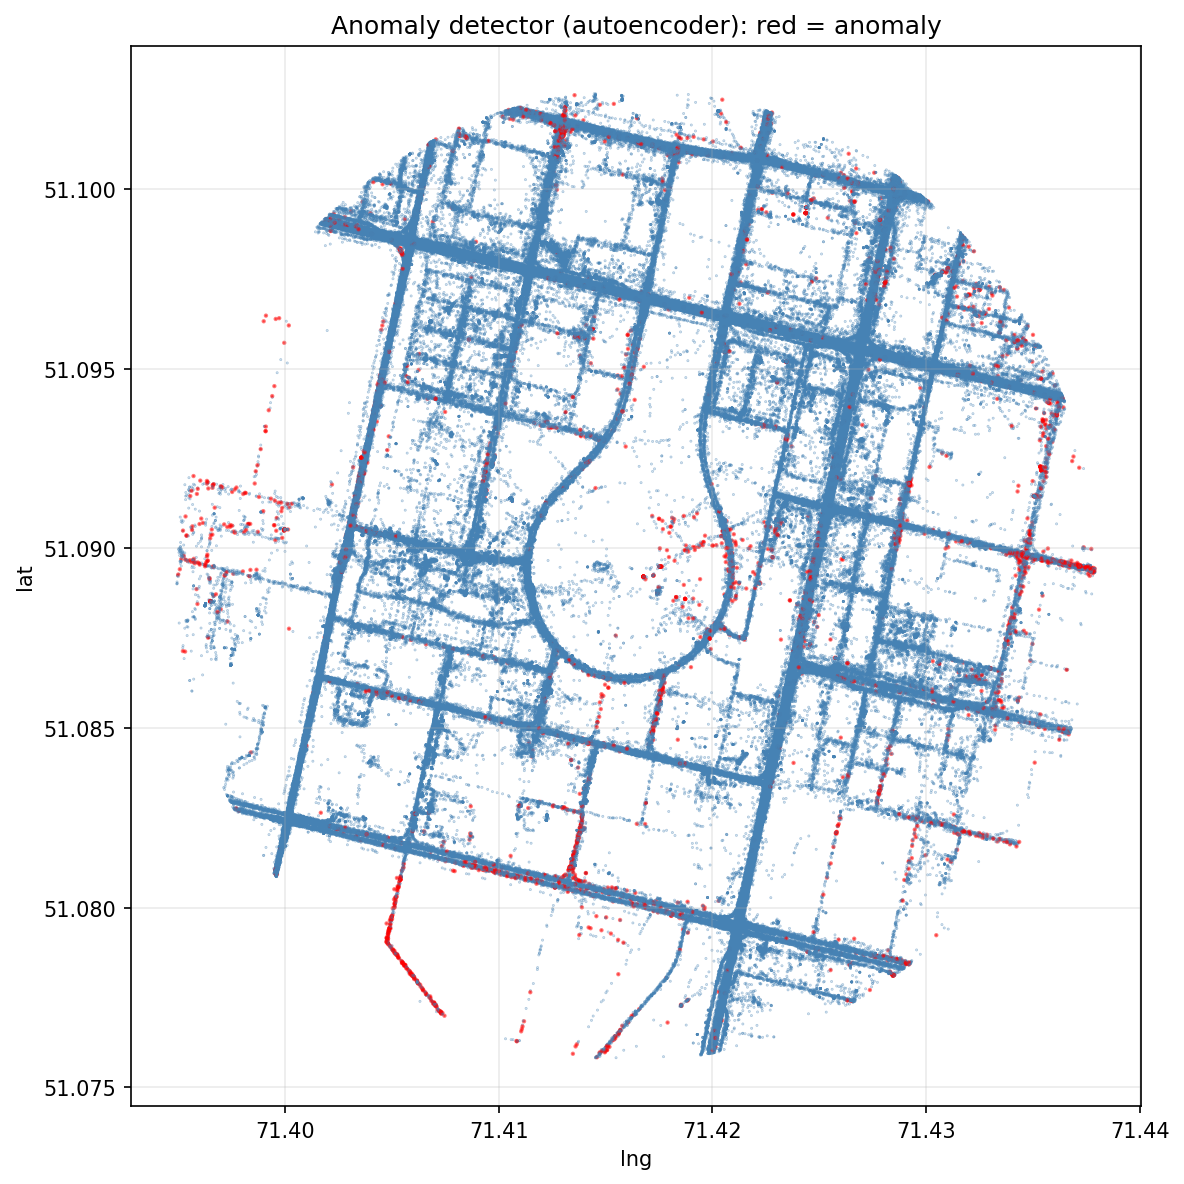

In [13]:
vis2 = df.sample(min(300_000, len(df)), random_state=2)
colors = np.where(vis2["is_anomaly"]==1, "red", "steelblue")
sizes  = np.where(vis2["is_anomaly"]==1, 1.2, 0.12)
plt.figure(figsize=(8,8), dpi=150)
plt.scatter(vis2["lng"], vis2["lat"], c=colors, s=sizes, alpha=0.5)
plt.title("Anomaly detector (autoencoder): red = anomaly")
plt.xlabel("lng"); plt.ylabel("lat"); plt.grid(True, linewidth=0.2)
plt.tight_layout(); plt.savefig("/kaggle/working/tf_anomalies_scatter.png", dpi=200); plt.show()

In [14]:
center_lat, center_lng = df["lat"].median(), df["lng"].median()

m_clusters = folium.Map(location=[center_lat, center_lng], zoom_start=11, tiles="cartodbpositron")
HeatMap(df[["lat","lng"]].sample(min(500_000, len(df)), random_state=0).values.tolist(),
        radius=13, blur=20, min_opacity=0.25).add_to(m_clusters)

for _, r in cluster_geo.iterrows():
    folium.CircleMarker(
        location=[r["lat_c"], r["lng_c"]],
        radius=7, color="#2b2b2b",
        fill=True, fill_color="#FFD166", fill_opacity=0.9,
        tooltip=f"cluster={int(r['cluster']) if 'cluster' in r else _} | trips={int(r['cnt']):,} | med spd={r['spd_med']:.1f} | anom%={r['anom_rate']*100:.1f}"
    ).add_to(m_clusters)

LayerControl().add_to(m_clusters)
m_clusters.save("/kaggle/working/folium_clusters.html")


m_anom = folium.Map(location=[center_lat, center_lng], zoom_start=12, tiles="cartodbpositron")
anom_df = df[df["is_anomaly"]==1]
if len(anom_df) > 0:
    points = anom_df[["lat","lng","anomaly_score"]].sample(min(250_000, len(anom_df)), random_state=3).values.tolist()
    HeatMap(points, radius=16, blur=26, min_opacity=0.35, max_zoom=18).add_to(m_anom)
else:
    folium.Marker([center_lat, center_lng], tooltip="No anomalies at current threshold").add_to(m_anom)

m_anom.save("/kaggle/working/folium_anomalies.html")

In [15]:
display(IFrame("/kaggle/working/folium_clusters.html", width=900, height=650))
display(IFrame("/kaggle/working/folium_anomalies.html", width=900, height=650))


In [16]:
out_cols = ["randomized_id","lat","lng","spd","azm","cluster","anomaly_score","is_anomaly"]
out_cols = [c for c in out_cols if c in df.columns]
df[out_cols].to_csv("/kaggle/working/clusters_kmeans.csv", index=False)

print("\nDONE. Files in /kaggle/working:")
print(" - tf_autoencoder.h5")
print(" - clusters_kmeans.csv")
print(" - tf_clusters_scatter.png, tf_anomalies_scatter.png")
print(" - folium_clusters.html, folium_anomalies.html")


DONE. Files in /kaggle/working:
 - tf_autoencoder.h5
 - clusters_kmeans.csv
 - tf_clusters_scatter.png, tf_anomalies_scatter.png
 - folium_clusters.html, folium_anomalies.html
